# Python Learn by Doing: Climate Change Indicators, Your Turn! Option 2 Answer Key

**Developed By:** Dr. Kerrie Geil, Mississippi State University

**Original Development Date:** May 2024

**Package Requirements:** xarray, netcdf4, numpy, pandas, scipy, matplotlib, jupyter, cartopy

**Links:** **[OSF project link](https://osf.io/zhpd5/)**, [link to this notebook on github](https://github.com/kerriegeil/MSU_py_training/blob/main/learn_by_doing/climate_change_indicators/assignments/climate_change_indicators_option2.ipynb)

---
**Assignment:**

Modify the TNx analysis to operate on gridded data (3-dimensional instead of the 1-dimensional data used in this notebook), performing all calculations at each grid cell. Include the relevant parts of the data cleaning section, calculate TNx, and then calculate the January TNx trend and pvalue. Present your results in a figure that shows the January TNx trend in C/year for each grid cell on a map if it is statistically significant at the 95% confidence level. Compare your results to climdex.org, looking at the trend in Jan TNx over CONUS for similar data years (1975-2019) and also for data years 1920-2019 from the Berkeley Earth Surface Temperature dataset.

&emsp;Hints:
- Use gridded tmin data for Mississippi from the file tmin_AgERA5_Mississippi_Daily_1979-2023.nc
- For data cleaning, do the steps that apply to tn only
    - nan for daily temperature greater than 70C or less than -70C
    - remove leap days
    - daily temperature outliers (5x std)
    - you may also want to use the function get_nans_per_month to plot the maximum number of nans per month found at each grid cell
- To use scipy.stats.linregress with multidimensional data, use **[xr.stack](https://docs.xarray.dev/en/latest/generated/xarray.DataArray.stack.html)** and a for loop or use nested for loops. Alternatively, write your own function to vectorize calculation of linear trend and pvalue.
- Plot the map of Jan trend values with units C/year, but only show the trend at grid cells that are statistically significant at the 95% confidence level or greater (use the p value and **[xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)** to mask out insignificant trends)
- Draw state boundaries on your map with cartopy (import cartopy.crs as ccrs, import cartopy.feature as cf) or use a different method/package of your choice
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of Jan TNx trend over CONUS using data years 1975-2019 from the BEST dataset
- Go to **[climdex.org](https://www.climdex.org/access/)** and get the png of Jan TNx trend over CONUS using data years 1920-2019 from the BEST dataset

# Import packages and define workspace

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as ss
import warnings
import os
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf

In [ ]:
# create a folder for data downloads
if not os.path.exists('./data'):
    os.makedirs('./data')

In [ ]:
# filenames to save data to
tmin_f='data/tmin_AgERA5_Mississippi_Daily_1979-2023.nc'

# Obtaining the data

We'll use the same AgERA5 dataset but this time we'll use data at all lat/lon grid points in Mississippi instead of just near Starkville. 

<br>
<font color="green"><b>
**NOTE: You only need to run the following urlretrieve cell once. The data file will then be located on your computer. This file totals approximately 96MB in size.**
</b></font> 

In [ ]:
# tmin for MS
url='https://osf.io/xj8h3/download' # url to the data
urlretrieve(url, tmin_f) # download and save data

# Data Cleaning

For the Starkville data, we know that the suggested data cleaning didn't change our data arrays (except for dropping leap days). But now, instead of working with 1 Starkville timeseries, we're working with 53 latitudes * 40 longitudes = 2120 different points in space that all have their own timeseries (3 dimensional data time, lat, lon).

We should do all data cleaning steps that apply to tn.

In [ ]:
tn = xr.open_dataarray(tmin_f)
tn = tn.squeeze()
tn

In [ ]:
#### nan for daily temperature greater than 70C (158F) or less than -70C (-94F)
# is tn>70C or tn<-70C?
((tn>70)|(tn<-70)).data.sum()

In [ ]:
#### drop leap days (i.e Feb 29th)

# create a boolean array of dim 'time' where leap days are True and all other days are False
isleapday=xr.where((tn.time.dt.day==29) & (tn.time.dt.month==2),True,False)

# drop leap days
tn=tn.where(~isleapday,drop=True) 

In [ ]:
# look at the nan situation

# a function that sums the number of nans in each month of data
def get_nans_per_month(data_in):
    month_groups=pd.MultiIndex.from_arrays([data_in.time['time.year'].data,data_in.time['time.month'].data])
    data_in.coords['month_groups']=('time',month_groups)    
    nancount=data_in.isnull().groupby('month_groups').sum()
    return nancount

nan_per_month=get_nans_per_month(tn.copy())

# the maximum number of nans per month at each grid cell
max_nan_per_month=nan_per_month.max('month_groups')

# plot it
fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
max_nan_per_month.plot(cmap='summer')
plt.show()

In [ ]:
#### daily temperature outliers 

# find the time-mean for each day of the year
tn_daily_mean=tn.groupby(tn.time.dt.dayofyear).mean('time')

# find the standard deviation for each day of the year
# .std on a timeseries of all nan will throw a runtime warning
# we can silence the warning with warnings.catch_warnings() and warnings.filterwarnings()
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")
    tn_stddev=tn.groupby(tn.time.dt.dayofyear).std('time')

# define daily outlier temperature as exceeding the mean +/- 5 times standard deviation
tn_outlier_upper, tn_outlier_lower=(tn_daily_mean+tn_stddev*5), (tn_daily_mean-tn_stddev*5)
print('tn',(tn.groupby(tn.time.dt.dayofyear)>tn_outlier_upper).data.sum(), (tn.groupby(tn.time.dt.dayofyear)<tn_outlier_lower).data.sum())

Turns out the only change we ended up making to our tn data array was dropping leap days.

# Monthly Maximum Value of Daily Minimum Temperature (TNx)

- max(each month of daily minimum temperature values) for each grid cell

Here we are inputting daily data and pulling out 1 value per month at each grid cell.

In [ ]:
# create monthly datetimes 
time_months=pd.date_range(tn.time.data[0],tn.time.data[-1],freq='MS')

In [ ]:
# create an index value for every month in the timeseries
month_groups=pd.MultiIndex.from_arrays([tn.time['time.year'].data,tn.time['time.month'].data])

# add the month_groups index the time coordinate labels
tn.coords['month_groups']=('time',month_groups)    
tn

In [ ]:
# now groupby month and find the maximum value of each month
TNx=tn.groupby('month_groups').max('time')
TNx

In [ ]:
# change the month_groups dim name and coordinate labels to datetimes
TNx=TNx.rename({'month_groups':'time'}) # renaming a coordinate and dimension
TNx=TNx.drop_vars(['time_level_0','time_level_1']) # we don't need these leftovers
TNx.coords['time']=('time',time_months) # replace coord labels 
TNx

Our TNx result is now 3-dimensional (time,lat,lon) instead of 1-dimensional like before when we were working with a single data point and had only the time dimension.

Let's select some of our 3D TNx array to plot

In [ ]:
# plot TNx timeseries for a single point from the 3D array

# using the first lat and lon
lat=TNx.lat[0]
lon=TNx.lon[0]

# # or this way will yield the same as above
# lat=TNx.lat.sel(lat=35.2,method='nearest')
# lon=TNx.lon.sel(lon=-91.8,method='nearest')

fig=plt.figure(figsize=(15,2))
TNx.sel(lat=lat,lon=lon).plot()
plt.title(f'monthly maximum value of daily minimum temperature (TNx) at lat {lat:.2f} lon {lon:.2f}')
plt.ylabel('degrees C')
plt.show()

In [ ]:
# plot the map of TNx for a single time

# using January 2020
ptime='2020-01'

fig=plt.figure(figsize=(5,5))
ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
TNx.sel(time=ptime).plot(cbar_kwargs={'label':'degrees C'})
plt.title('TNx for '+ptime)
plt.show()

# Trend analysis

In [ ]:
# subset to only January

TNx_jan=TNx.where(TNx.time.dt.month==1,drop=True)
TNx_jan

scipy.stats.linregress only operates on 1-dimensional data arrays so if we want to stick with this function to calculate the linear regression information, we will need to either use nested loops or .stack plus one loop. Note, it's best to avoid looping if you can in python, because it will be much slower than vectorized computation. Here, I will use .stack and a single loop to build arrays for trend and pval with scipy.stats.linregress 

However, if you were operating on a larger dataset (higher spatial resolution or global extent) this technique of calculating trend and pval may be too slow. At the end of this notebook, I'll show a custom function for linear regression on 3D xarray data array that doesn't stack or loop, which would be much faster on big data.

In [ ]:
# stack lat and lon dimensions into a single dimension called space

TNx_jan_stacked=TNx_jan.stack(space=['lat','lon'])
TNx_jan_stacked

In [ ]:
# create two arrays of dimension 'space' to hold our results and initialize to nan

pval=TNx_jan_stacked.isel(time=0).copy()  # copy a single time from our stacked array
pval[:]=np.nan  # initialize to nan
del pval['time']  # get rid of the time coordinate label that isn't relevant

trend=TNx_jan_stacked.isel(time=0).copy()
trend[:]=np.nan
del trend['time']

pval

In [ ]:
# linear regression with scipy using .stack and a for loop

xvals=TNx_jan.time.dt.year

for i,point in enumerate(pval.space):
    reg_info=ss.linregress(xvals,TNx_jan_stacked.sel(space=point))
    pval[i]=reg_info.pvalue
    trend[i]=reg_info.slope # C/year     
trend

In [ ]:
# now unstack the results back to two dimensions lat,lon

pval=pval.unstack()
trend=trend.unstack()
trend

In [ ]:
# plot the trend and pval results separately

fig=plt.figure(figsize=(10,5))

ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
trend.plot(cbar_kwargs={'label':'C/year'})
plt.title('TNx Jan trend')

ax=fig.add_subplot(122,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
pval.plot()
plt.title('TNx Jan trend p value')

plt.show()

In [ ]:
# plot the trend where statistical significance is at the 95% condifidence level or greater (using pval as a mask)

fig=plt.figure(figsize=(10,5))

ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
trend.where(pval<0.05).plot(cbar_kwargs={'label':'C/year'})
plt.title('TNx Jan trend (p < 0.05)')
# plt.savefig('figs/cci_option2_figure.png')
plt.show()

# Trend analysis with custom regression function 

vectorized (multiple dimensions, no stacking, no looping) linear regression with p values 

This is the approach I would take with bigger data because loops are slow

In [ ]:
def linear_reg(x,y):
    
    # Compute x length, and x and y mean and standard deviation
    n = x.shape[0]
    
    xmean = x.mean('time')
    xstd = x.std('time') 
    
    ymean = y.mean('time')
    ystd = y.std('time')
    
    # here's where you would compute equivalent sample size
    # if you wanted to account for autocorrelation
    
    # Compute covariance 
    # including min_count=1 will return nan instead of 0 at the ocean points
    cov = ((x - xmean)*(y - ymean)).sum('time',min_count=1)/n

    # Compute correlation
    cor = cov/(xstd*ystd)

    # Compute regression slope 
    slope = cov/(xstd**2)

    # Compute t statistc and p-value
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    p = ss.t.sf(abs(tstats), n-2)*2 # *2 for two-sided test
    p = xr.DataArray(p, dims=cor.dims, coords=cor.coords)

    return slope,p

In [ ]:
# call our custom function
slope,p=linear_reg(TNx_jan.time.dt.year,TNx_jan)

Don't worry about the degrees of freedom warning. The ystd line throws this warning because a few of the grid cells in our data array are all nan (the ocean grid cells). If you want to turn off this warning you could use warnings.catch_warnings and warnings.filterwarnings like we did in the data cleaning section

In [ ]:
# plot the trend and pval results separately

fig=plt.figure(figsize=(10,5))

ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
slope.plot(cbar_kwargs={'label':'C/year'})
plt.title('TNx Jan trend')

ax=fig.add_subplot(122,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
p.plot()
plt.title('TNx Jan trend p value')

plt.show()

In [ ]:
# plot the trend where statistical significance is at the 90% condifidence level or greater (using pval as a mask)

fig=plt.figure(figsize=(10,5))

ax=fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.add_feature(cf.STATES.with_scale("50m"),lw=0.3)
slope.where(p<0.05).plot(cbar_kwargs={'label':'C/year'})
plt.title('TNx Jan trend (p < 0.05)')

plt.show()

# Difference betwee scipy.stats.linregress and custom regression function

If we plot the difference in trend between our custom function and scipy.stats.linregress we would expect to see just noise (a random pattern of very small differences) 

In [ ]:
(slope-trend).plot()

We should also see very small differences in p values from our custom function and scipy.stats.linregress 

In [ ]:
(p-pval).plot()

# Conclusions

The trend in TNx is statisically significant at the 95% confidence level across all of Mississippi except for one small spot in extreme southest MS.

We find a similar result for Mississippi from climdex.org, using BEST data over the years 1975-2019 to calculate TNx January trend.

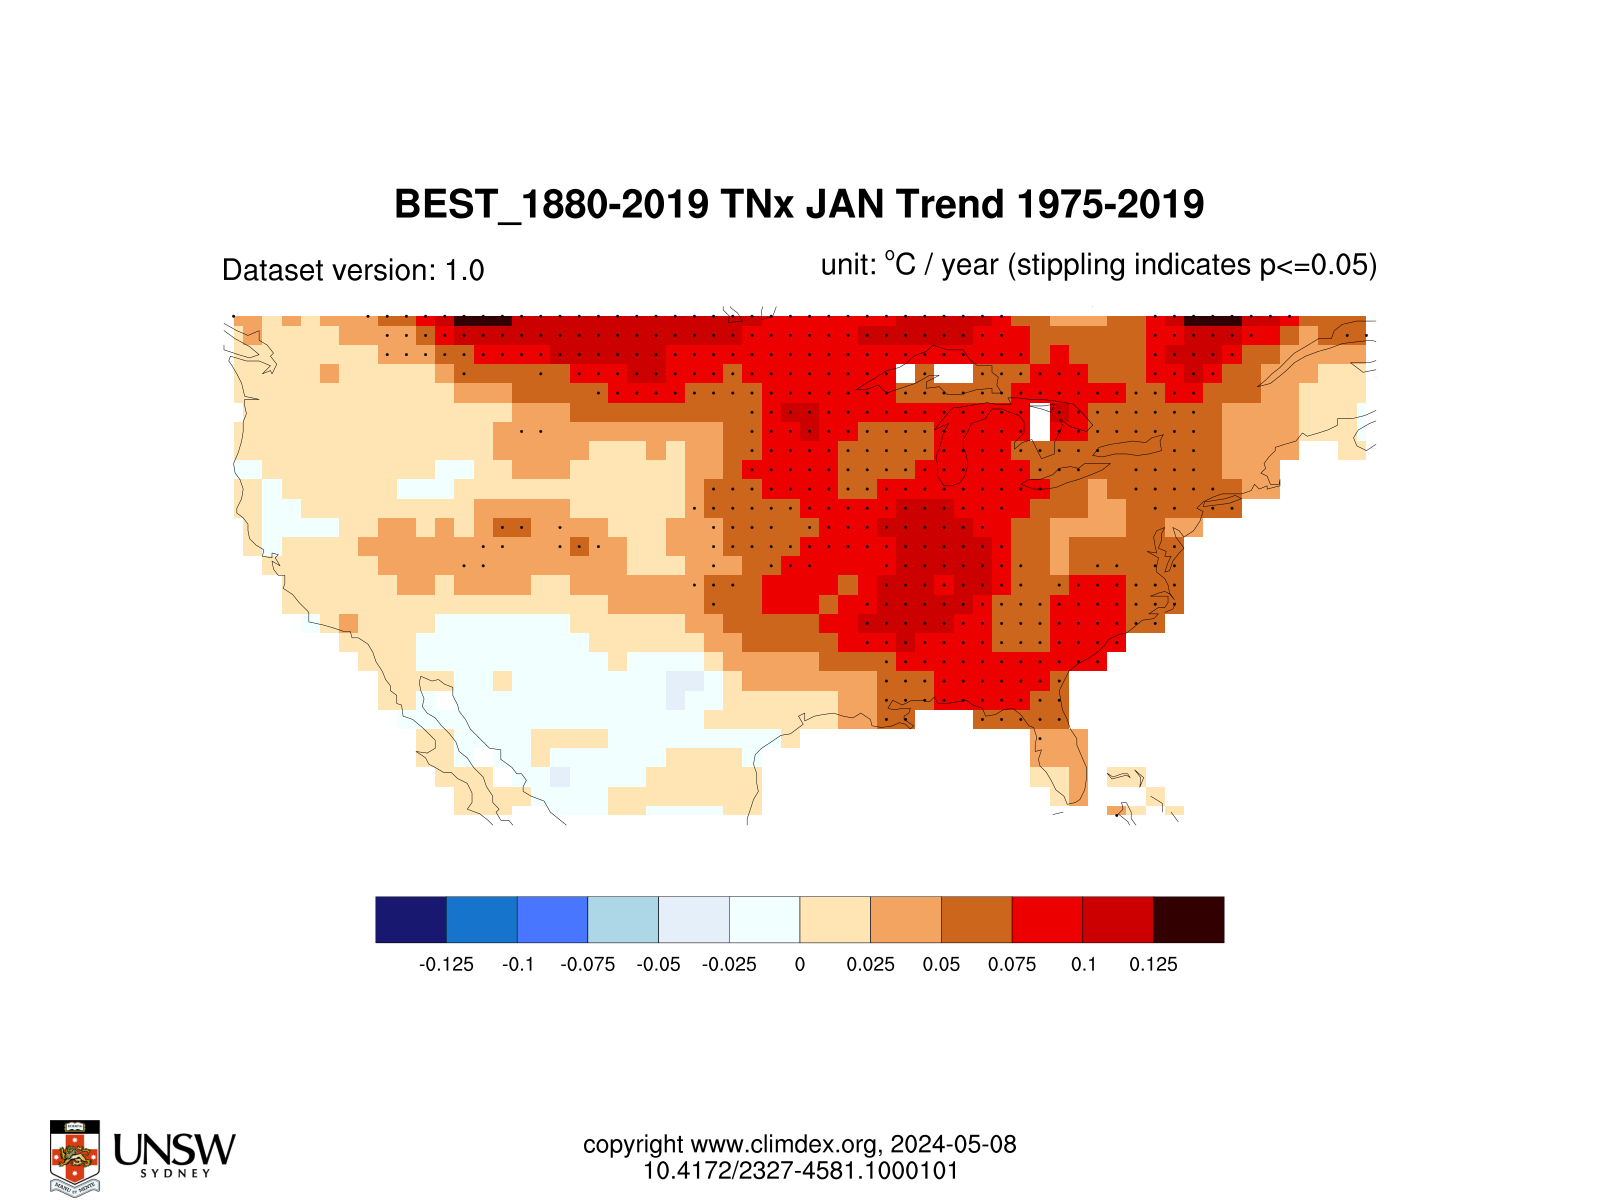

<br>
<br>

However, if we look if we look at the 100-year trend (1920-2019) in Jan TNx we see no statistical significance over Mississippi. 

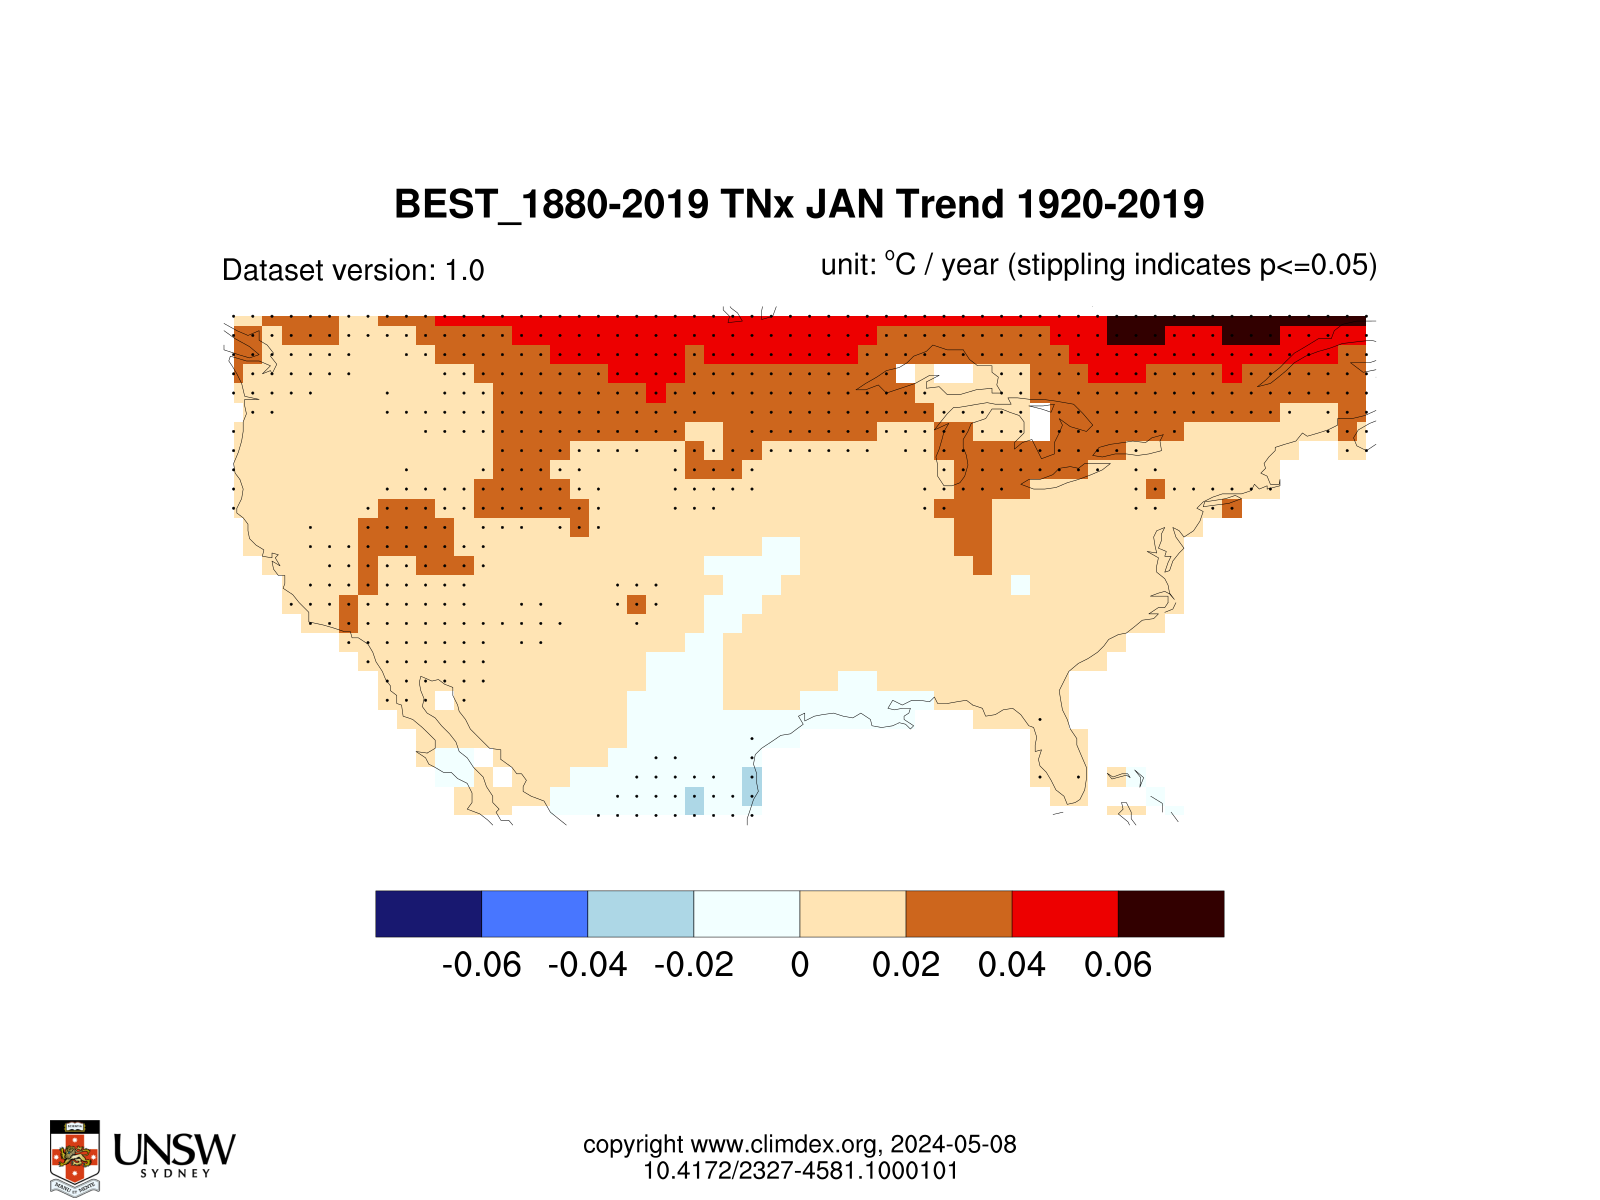